In [1]:
# Access the autogen libraries.
import sys
sys.path.append('..')

# Introduction to autogen.
This notebook is meant to give an idea for what autogen is for, and why it might be useful to you.

The purpose of autogen is to automate some of the mundane workflow tasks associated with running QMC.
* Writing input files, keeping track of input parameters.
* Reading and checking results are not completely unreasonable.
* Running jobs in batch, waiting for them to finish.
* Restarting jobs that need more time to finish.
* Keeping track of data and where it comes from.

### Hydrogen example
To illustrate how autogen is supposed to work, here's a simple example of an hydrogen molecule VMC run. 

To learn how to set up a run like this, you should check out the other notebooks, which walk step-by-step through how this works.
For now, just glance over this code and check out the results.

In [2]:
from autopyscf import PySCFWriter, PySCFReader, dm_set_spins
from autorunner import PySCFRunnerLocal,RunnerLocal
from trialfunc import SlaterJastrow
from variance import VarianceWriter, VarianceReader
from manager import PySCFManager, QWalkManager

path='00-scratch'

# A hydrogen molecule.
h2='\n'.join([
    'H 0.0 0.0 0.0 ',
    'H 0.74 0.0 0.0 '
])

# Input parameters for SCF calculation.
pyscf_writer=PySCFWriter({
      'xyz':h2,
      'dft':'pbe,pbe',
      'spin':0,
      'dm_generator':dm_set_spins([1,-1],[]),
      'pyscf_path':sys.path
    })  

vmc_writer=VarianceWriter()

# Manage the PySCF job.
scfmanager=PySCFManager(
    name='h2_pbe',
    path=path,
    writer=pyscf_writer,
    runner=PySCFRunnerLocal()
  )

# Manage the VMC job.
voptmanager=QWalkManager(
      name='h2_vopt',
      path=path,
      writer=VarianceWriter(),
      reader=VarianceReader(),
      trialfunc=SlaterJastrow(scfmanager),
      runner=RunnerLocal(np=4)
    )

In [3]:
while not voptmanager.completed:
    voptmanager.nextstep()

QWalkManager@00-scratch/h2_vopt : next step.
QWalkManager@00-scratch/h2_vopt : checking trial function.
PySCFManager@00-scratch/h2_pbe : next step.
PySCFManager@00-scratch/h2_pbe : h2_pbe status= not_started
PySCFRunnerLocal : executed python3 h2_pbe.py > h2_pbe.py.o
VarianceWriter : Trial function not ready. Postponing input file generation.
QWalkManager@00-scratch/h2_vopt : h2_vopt status= not_started
QWalkManager@00-scratch/h2_vopt : next step.
QWalkManager@00-scratch/h2_vopt : checking trial function.
PySCFManager@00-scratch/h2_pbe : next step.
PySCFManager@00-scratch/h2_pbe : h2_pbe status= ready_for_analysis
PySCFManager@00-scratch/h2_pbe : h2_pbe status= done, task complete.
PySCFManager@00-scratch/h2_pbe : h2_pbe generating QWalk files.
QWalkManager@00-scratch/h2_vopt : h2_vopt status= not_started
QWalkManager@00-scratch/h2_vopt : h2_vopt status= submitted
RunnerLocal : executed mpirun -n 4 /home/brian/bin/qwalk h2_vopt.variance &> h2_vopt.variance.out
QWalkManager@00-scratch/h

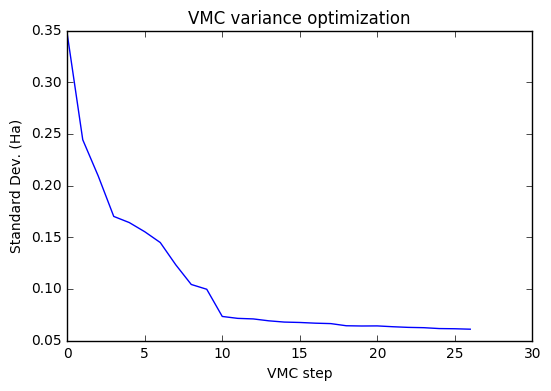

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax=plt.subplots(1,1)
ax.plot(voptmanager.reader.output['sigma'])
ax.set_title('VMC variance optimization')
ax.set_xlabel('VMC step')
ax.set_ylabel('Standard Dev. (Ha)')

# First step: writing the input (01-writing_input.ipynb).